# Look-ahead sampling

In addition to various static (STAT) and dynamic (DYN) samplers implemented in particular using shared-memory multi-processing and distributed processing via a Redis server, pyABC provides a run-time minimizing so-called "look-ahead" (LA) sampler, which is an extension of DYN that uses free workers at the end of a generation in order to start sampling from the next generation already, based on a preliminary proposal distribution. It is particularly useful in the presence of heterogenous model runtimes, in which case STAT and also DYN may wait for single long-running simulations to finish before continuing with the next generation.

In this notebook, we demonstrate the usage of this method in pyABC. If the notebook is run on a low number of cores (<< population size), advantages of LA do not get structurally apparent. See the corresponding publication for an in-depth analysis on high-performance infrastructure. For typical applications, we observed on average a reduction of the total wall-time of 10%-20% of LA over DYN (and a major reduction of 50% of DYN compared to STAT) when the number of workers roughly equals the population size, with reductions of up to nearly 50% when the number of workers far exceeds the population size.

In [1]:
import pyabc
import matplotlib.pyplot as plt
import os
import tempfile
import numpy as np
import scipy as sp
import pandas as pd
import time
import logging

logging.getLogger("ABC.Sampler").setLevel("DEBUG")

pyabc.settings.set_figure_params('pyabc')  # for beautified plots

The LA sampler is implemented via Redis. In practice, server and workers need to be started as described in [the documentation](https://pyabc.readthedocs.io/en/latest/sampler.html), e.g. as follows: Start a redis server::

    redis-server --port 6379
 
and connect workers to it via::

    abc-redis-worker --host=localhost --port=6379 --processes=4 --runtime=2h

For convenience, in this notebook we use an integrated server starter that runs both server and workers locally.

Next, we define a simple ODE based test model (similar to [this notebook](https://pyabc.readthedocs.io/en/latest/examples/conversion_reaction.html)) to perform the parameter inference on. To emulate runtime heterogeneity, which is often observed in practice when e.g. the number of reactions to be simulated is parameter-dependent, we randomly extend each model evaluation time.

In [2]:
theta1_true, theta2_true = np.exp([-2.5, -2])
theta_true = {"theta1": theta1_true, "theta2": theta2_true}
measurement_times = np.arange(11)
init = np.array([1, 0])
sigma = 0.03

def f(y, t0, theta1, theta2):
    x1, x2 = y
    dx1 = - theta1 * x1 + theta2 * x2
    dx2 =   theta1 * x1 - theta2 * x2
    return dx1, dx2


def model(pars):
    # numerical integration
    sol = sp.integrate.odeint(
             f, init, measurement_times,
             args=(pars["theta1"],pars["theta2"]))
    # we only observe species 2
    sol = sol[:, 1]

    # add multiplicative measurement noise to ODE solution
    noise = np.random.normal(1, 0.03, size=len(sol))
    noisysol = sol * np.random.normal(1, sigma, size=len(sol))

    # sleep a little to emulate heterogeneous run times
    sleep_s = np.random.lognormal(mean=-4, sigma=1.5)
    time.sleep(sleep_s)

    return {"X_2": noisysol}


def distance(simulation, data):
    return np.absolute(data["X_2"] - simulation["X_2"]).sum()

measurement_data = model(theta_true)

parameter_prior = pyabc.Distribution(
    theta1=pyabc.RV("uniform", 0, 1), theta2=pyabc.RV("uniform", 0, 1))

### Sampling

First, set some run parameters (epsilons, population size etc.)

In [3]:
db_file = f"sqlite:///{os.path.join(tempfile.gettempdir(), 'test.db')}"

# note: this population size is for demonstration purposes,
#  it is far too low for applications
pop_size = 100
eps_list = np.logspace(start=np.log2(8), stop=np.log2(0.5), num=5, base=2)
eps = pyabc.ListEpsilon(eps_list)

# run more often to get average statistics
iters = 1
iters_la = iters
iters_dyn = iters
iters_stat = iters

In practice, the below `RedisEvalParallelSamplerServerStarter` should be replaced by a `RedisEvalParallelSampler` with the correct host IP and port.

Perform sampling using DYN scheduling:

In [4]:
redis_sampler = pyabc.sampler.RedisEvalParallelSamplerServerStarter(
    look_ahead=False, workers=pyabc.nr_cores_available(),
    # wait_for_all_samples=True,
)
hs_dyn = []

for i in range(0, iters_dyn):
    abc = pyabc.ABCSMC(
        models=model,
        parameter_priors=parameter_prior,
        distance_function=distance,
        population_size=pop_size,
        sampler=redis_sampler,
        eps=eps,
    )

    abc.new(db_file, measurement_data)
    h = abc.run(max_nr_populations=len(eps_list))
    hs_dyn.append(h)

ABC.Sampler INFO: Start redis worker. Max run time 7200.0s, HOST=yshmpc, PID=340560
ABC.Sampler INFO: Start redis worker. Max run time 7200.0s, HOST=yshmpc, PID=340563
ABC.Sampler INFO: Start redis worker. Max run time 7200.0s, HOST=yshmpc, PID=340566
ABC.Sampler INFO: Start redis worker. Max run time 7200.0s, HOST=yshmpc, PID=340569
ABC.Sampler DEBUG: Redis sampler: host=localhost port=61019
ABC.History INFO: Start <ABCSMC id=1, start_time=2021-06-15 13:06:02>
ABC INFO: t: 0, eps: 8.00000000e+00.
ABC.Sampler INFO: Begin generation 0, batch size 1. I am worker 3
ABC.Sampler INFO: Begin generation 0, batch size 1. I am worker 2
ABC.Sampler INFO: Begin generation 0, batch size 1. I am worker 4
ABC.Sampler INFO: Begin generation 0, batch size 1. I am worker 1
ABC.Sampler DEBUG: After 100 acceptances, 3 simulations busy, thereof 0 earlier.
ABC.Sampler INFO: Finished generation 0, did 26 samples. Simulation time: 1.61s, total time 2.10.
ABC.Sampler DEBUG: Sampling for time t: {'t': 0, 'n_ev

Note that the dynamical Redis sampler also has an option `wait_for_all_particles=False`, which was newly introduced in version 0.10.15 and already speeds things up by keeping track of which simulations need to be waited for exactly. The previous implementation is equivalent to `False`, in which case all started samples are waited for, including ones that were started after the last accepted one and are thus disregarded anyway.

Perform sampling using LA scheduling:

In [5]:
logfile = tempfile.mkstemp(prefix="redis_log", suffix=".csv")[1]
redis_sampler = pyabc.sampler.RedisEvalParallelSamplerServerStarter(
    # main field: in generation t already preemptively sample for t+1 if cores
    #  are available
    look_ahead=True,
    # whether to delay evaluation until the next generation has really
    #  started, this is necessary if any component s.a. eps, distance is
    #  adaptive
    look_ahead_delay_evaluation=True,
    # determines how many samples to sample preemptively maximally without
    #  checking
    max_n_eval_look_ahead_factor=2,
    # a file for some sampler debugging output
    log_file=logfile,
    workers=pyabc.nr_cores_available(),
)

hs_la = []

for i in range(0,iters_la):
    abc = pyabc.ABCSMC(
        models=model,
        parameter_priors=parameter_prior,
        distance_function=distance,
        population_size=pop_size,
        sampler=redis_sampler,
        eps=eps,
    )

    abc.new(db_file, measurement_data);
    h = abc.run(max_nr_populations=len(eps_list))
    hs_la.append(h)

ABC.Sampler INFO: Start redis worker. Max run time 7200.0s, HOST=yshmpc, PID=340680
ABC.Sampler INFO: Start redis worker. Max run time 7200.0s, HOST=yshmpc, PID=340683
ABC.Sampler INFO: Start redis worker. Max run time 7200.0s, HOST=yshmpc, PID=340686
ABC.Sampler INFO: Start redis worker. Max run time 7200.0s, HOST=yshmpc, PID=340689
ABC.Sampler DEBUG: Redis sampler: host=localhost port=61020
ABC.History INFO: Start <ABCSMC id=2, start_time=2021-06-15 13:06:41>
ABC INFO: t: 0, eps: 8.00000000e+00.
ABC.Sampler INFO: Begin generation 0, batch size 1. I am worker 2
ABC.Sampler INFO: Begin generation 0, batch size 1. I am worker 1
ABC.Sampler INFO: Begin generation 0, batch size 1. I am worker 4
ABC.Sampler INFO: Begin generation 0, batch size 1. I am worker 3
ABC.Sampler DEBUG: After 100 acceptances, 2 simulations busy, thereof 1 earlier.
ABC.Sampler INFO: Finished generation 0, did 20 samples. Simulation time: 1.92s, total time 2.30.
ABC.Sampler INFO: Finished generation 0, did 23 sample

The LA sampler uses a preliminary proposal distribution based on the last generation's preliminarily accepted particles, to start sampling for the next generation as soon as workers become idle. When the last generation is actually done, the proposal is updated and continued with. The accepted population can then consist of accepted particles from both preliminary and actual proposals, which are in pyABC weighted in order to maximize the overall effective sample size.

If the problem possesses a highly skewed parameter-runtime structure (e.g. with fast runtimes in one regime, slow ones in another), then theoretically LA can lead to fast estimates that are however biased towards that fast regime, because the preliminary proposal distribution may be biased. In practical applications, we have observed similarly stable posterior approximations with all of STAT, DYN, LA, i.e. no such problem, but one may want to keep this in mind.

Perform sampling using STAT scheduling, which is known to be less efficient than DYN for large numbers of workers, but may be competitive for few (see e.g. [the publication](https://doi.org/10.1093/bioinformatics/bty361)):

In [6]:
redis_sampler = pyabc.sampler.RedisStaticSamplerServerStarter(
    workers=pyabc.nr_cores_available(),
)

hs_stat=[]

for i in range(0, iters_stat):
    abc = pyabc.ABCSMC(models=model,
        parameter_priors=parameter_prior,
        distance_function=distance,
        population_size=pop_size,
        sampler=redis_sampler,
        eps=eps,
    )

    abc.new(db_file, measurement_data);
    h = abc.run(max_nr_populations=len(eps_list))
    hs_stat.append(h)

ABC.Sampler INFO: Start redis worker. Max run time 7200.0s, HOST=yshmpc, PID=340805
ABC.Sampler INFO: Start redis worker. Max run time 7200.0s, HOST=yshmpc, PID=340806
ABC.Sampler INFO: Start redis worker. Max run time 7200.0s, HOST=yshmpc, PID=340811
ABC.Sampler INFO: Start redis worker. Max run time 7200.0s, HOST=yshmpc, PID=340814
ABC.Sampler DEBUG: Redis sampler: host=localhost port=61021
ABC.History INFO: Start <ABCSMC id=3, start_time=2021-06-15 13:07:14>
ABC INFO: t: 0, eps: 8.00000000e+00.
ABC.Sampler INFO: Begin generation 0. I am worker 4
ABC.Sampler INFO: Begin generation 0. I am worker 1
ABC.Sampler INFO: Begin generation 0. I am worker 3
ABC.Sampler INFO: Begin generation 0. I am worker 2
ABC.Sampler INFO: I'm a sad jobless worker. Finished generation 0, did 34 samples. Simulation time: 1.34s, total time 1.71.
ABC.Sampler INFO: I'm a sad jobless worker. Finished generation 0, did 17 samples. Simulation time: 1.42s, total time 1.72.
ABC.Sampler INFO: I'm a sad jobless worke

### Results

The posterior distributions of all samplers should look similar for large enough population sizes. Given the low population size used here, they may not.

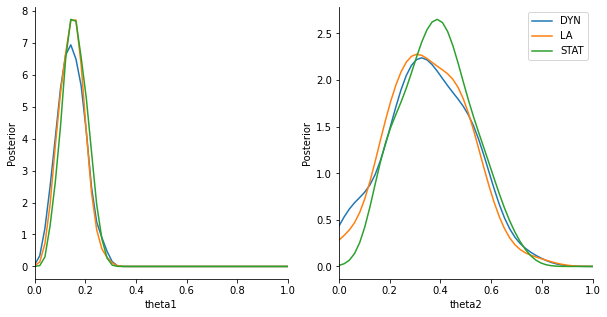

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for h in hs_dyn:
    df, w = h.get_distribution(m=0, t=h.max_t)
    for par, ax in zip(["theta1", "theta2"], axes):
        pyabc.visualization.plot_kde_1d(
            df, w, x=par, ax=ax, color="C0", xmin=0, xmax=1,
            label="DYN")

for h in hs_la:
    df, w = h.get_distribution(m=0, t=h.max_t)
    for par, ax in zip(["theta1", "theta2"], axes):
        pyabc.visualization.plot_kde_1d(
            df, w, x=par, ax=ax, color="C1", xmin=0, xmax=1,
            label="LA")
        
for h in hs_stat:
    df, w = h.get_distribution(m=0, t=h.max_t)
    for par, ax in zip(["theta1", "theta2"], axes):
        pyabc.visualization.plot_kde_1d(
            df, w, x=par, ax=ax, color="C2", xmin=0, xmax=1,
            label="STAT")

plt.legend()

The main reason for using an LA based concept is an accelerated result generation, as all cores are used at almost all times.
As we here only have few cores and thus workers on our local system (like 4 or 8) and we only use a very small population size, the difference is fairly random and hardly visible.
The effect becomes more apparent when working on large-scale infrastructure with dozens or hundreds of workers.

Epsilon over wall-time (for typical applications one would expect this to be lowest for LA and highest for STAT):

<AxesSubplot:title={'center':'Epsilon over walltime'}, xlabel='Time [s]', ylabel='Epsilon'>

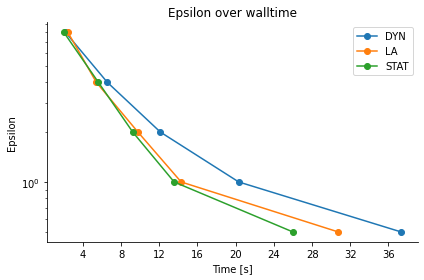

In [8]:
hs = [*hs_dyn, *hs_la, *hs_stat]
labels = [*["DYN"] * len(hs_dyn), *["LA"] * len(hs_la), *["STAT"] * len(hs_stat)]

pyabc.visualization.plot_eps_walltime(hs, labels)

# for separate plotting
# pyabc.visualization.plot_eps_walltime(hs[:iters], labels[:iters])
# pyabc.visualization.plot_eps_walltime(hs[iters:2*iters], labels[iters:2*iters])
# pyabc.visualization.plot_eps_walltime(hs[2*iters:], labels[2*iters:])

Total number of samples (for typical applications one would expect this to be lowest for STAT and highest for LA):

<AxesSubplot:title={'center':'Total required samples'}, xlabel='Run', ylabel='Total samples'>

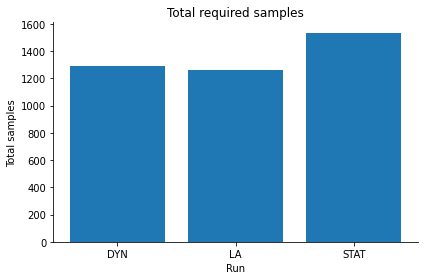

In [9]:
pyabc.visualization.plot_total_sample_numbers(hs, labels)

Let us investigate the behavior of the look-ahead sampler in a bit more detail.

Number of look-ahead and actual (=with the final proposal) samples:

<AxesSubplot:title={'center':'Total evaluations'}, xlabel='Population index', ylabel='Evaluations'>

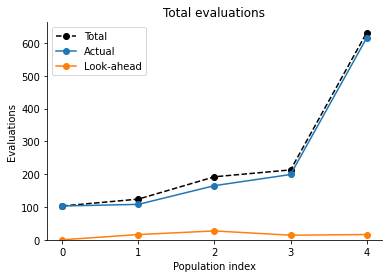

In [10]:
pyabc.visualization.plot_lookahead_evaluations(
    sampler_df=logfile,
    # relative=True,
)

Composition of final accepted population:

<AxesSubplot:title={'center':'Composition of final acceptances'}, xlabel='Population index', ylabel='Final acceptances'>

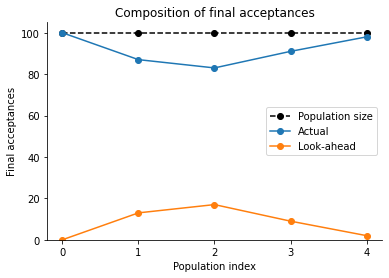

In [11]:
pyabc.visualization.plot_lookahead_final_acceptance_fractions(
    logfile, hs_la[0],
    # relative=True,
)

Acceptance rates in look-ahead and actual mode:

<AxesSubplot:title={'center':'Acceptance rates'}, xlabel='Population index', ylabel='Acceptance rate'>

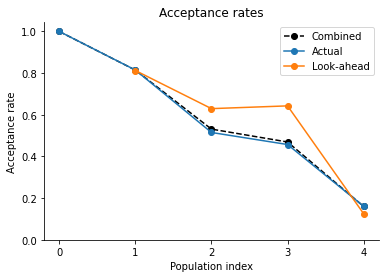

In [12]:
pyabc.visualization.plot_lookahead_acceptance_rates(sampler_df=logfile)

For details on the use and options of the various samplers, see the [API documentation](https://pyabc.readthedocs.io/en/latest/api_sampler.html). Note that unlike STAT and DYN, LA is currently only implemented via Redis, but e.g. not for multi-processing, which typically does not scale beyond a few dozen workers.